In [1]:
import pickle as p

(my_network, my_time_series) = p.load(open('data/GPSData.p', 'rb'))

In [2]:
import numpy as np

def convert_to_local_planar(lon, lat, reflon, reflat):
    earth_r = 6371000;  # earth's radius
    x_deg = np.subtract(lon, reflon);
    y_deg = np.subtract(lat, reflat);
    x_meters = x_deg * earth_r * np.cos(np.deg2rad(lat)) * 2 * np.pi / 360;
    y_meters = y_deg * earth_r * 2 * np.pi / 360;
    return [x_meters, y_meters];

def stations_to_huang_non_utm(stations):
    elon, nlat = [], [];
    elon_all = [item.elon for item in stations];
    nlat_all = [item.nlat for item in stations];
    reflon = np.min(elon_all);
    reflat = np.min(nlat_all);
    for item in stations:
        [x_meters, y_meters] = convert_to_local_planar(item.elon, item.nlat, reflon, reflat)
        elon.append(x_meters);
        nlat.append(y_meters);
    return [np.array(elon), np.array(nlat)];

In [3]:
reflon = np.min([item.elon for item in my_network.get_stations()])
reflat = np.min([item.nlat for item in my_network.get_stations()])

[elon, nlat] = stations_to_huang_non_utm(my_network.get_stations())


In [4]:
HSL_EC = (-119.021559, 37.613324)
strain_range=[-119.2,-118.6,37.47,37.82]
grid_inc = [0.001, 0.001]

ylats = np.arange(strain_range[2], strain_range[3]+0.00001, grid_inc[1])
xlons = np.arange(strain_range[0], strain_range[1]+0.00001, grid_inc[0])

gridX = np.zeros((len(ylats), len(xlons)))
gridY = np.zeros((len(ylats), len(xlons)))

for j, xlon in enumerate(xlons):
    for i, ylat in enumerate(ylats):
        [gridX_loc, gridY_loc] = convert_to_local_planar(xlon, ylat, reflon, reflat)
        gridX[i,j] = gridX_loc
        gridY[i,j] = gridY_loc

In [5]:
from datetime import datetime
from gpsutils import gps_data_for_date_from_timeseries

date = datetime(2018, 1, 21)
gpsdata = gps_data_for_date_from_timeseries(date, my_time_series)

In [6]:
def find_index_by_name(iterable, name):
    for i, it in enumerate(iterable):
        if it.name == name:
            return i
    return None

def find_item_by_name(iterable, name):
    for it in iterable:
        if it.name == name:
            return it
    return None

In [7]:
names = [g.name for g in gpsdata if g.e is not np.nan and g.n is not np.nan]
xi = np.array([elon[find_index_by_name(my_network.get_stations(), name)] for name in names])
yi = np.array([nlat[find_index_by_name(my_network.get_stations(), name)] for name in names])
uz = np.array([find_item_by_name(gpsdata, name).u for name in names])
ux = np.array([find_item_by_name(gpsdata, name).e for name in names])
uy = np.array([find_item_by_name(gpsdata, name).n for name in names])

In [8]:
from scipy.interpolate import Rbf

rb_fz = Rbf(xi, yi, uz, function='thin_plate')
rb_fx = Rbf(xi, yi, ux, function='thin_plate')
rb_fy = Rbf(xi, yi, uy, function='thin_plate')

In [9]:
UZ = np.zeros_like(gridX)
UY = np.zeros_like(gridX)
UX = np.zeros_like(gridX)

for j, gx in enumerate(gridX[1,:]):
    for i, gy in enumerate(gridY[:,1]):
        UZ[i,j] = rb_fz(gridX[i,j], gridY[i,j])
        UY[i,j] = rb_fy(gridX[i,j], gridY[i,j])
        UX[i,j] = rb_fz(gridX[i,j], gridY[i,j])

In [10]:
import matplotlib.pylab as plt

dx = np.mean(gridX[1:-1,2:] -  gridX[1:-1,0:-2])
dy = np.mean(gridY[2:,1:-1] -  gridY[0:-2,1:-1])

e11, dV1dx2 = np.gradient(UX, dx, dy)
dV2dx1, e22 = np.gradient(UY, dx, dy)
dV3dx1, dV3dx2 = np.gradient(UZ, dx, dy)
    
e12 = 0.5*(dV1dx2 + dV2dx1)
e13 = 0.5*(dV3dx1)
e23 = 0.5*(dV3dx2)

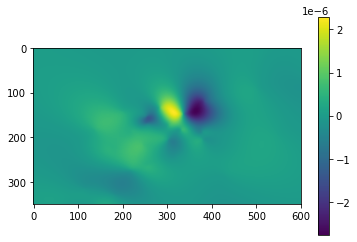

In [11]:
plt.imshow(e12)
plt.colorbar()

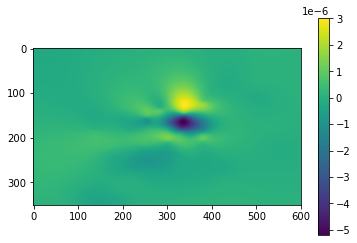

In [12]:
plt.imshow(e13)
plt.colorbar()

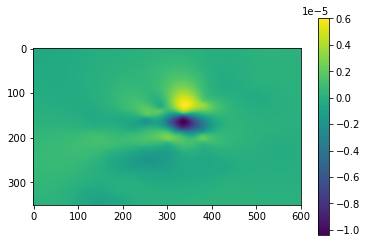

In [13]:
plt.imshow(e11)
plt.colorbar()

In [14]:
import pickle as p
(t, co2_ts, co2_pred, co2_erfc_pred, b) = p.load(open('results/ec_time_series.p', 'rb'))
(my_network, my_time_series) = p.load(open('data/GPSData.p', 'rb'))

HSL_EC = (-119.021559, 37.613324)
strain_calculator = my_network.get_strain_calculator([0.005, 0.005], strain_method='gpsgridder', strain_range=[HSL_EC[0]-0.005,HSL_EC[0]+0.0051,HSL_EC[1]-0.005,HSL_EC[1]+0.005])

import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from plotting import plot_dilatation
from gpsutils import strain_from_network_for_date
import numpy as np

def calculate_stresses(E, nu, azimuth, date):
    lons, lats, rot, exx, exy, eyy = strain_from_network_for_date(strain_calculator, my_time_series, np.datetime64(date), field_prefix = 'filtered')
    e = np.array([[exx[1,1], exy[1,1]],[exy[1,1], eyy[1,1]]])# / 1E9 # strains are reported in nanostrains
    s = E / (1-np.power(nu,2)) * ((1 - nu)*e + nu*np.trace(e)*np.identity(2))
    strike_v = np.array([np.cos(np.deg2rad(90.0-azimuth)), np.sin(np.deg2rad(90-azimuth)), 0])
    vertical = np.array([0, 0, 1])
    n = np.cross(strike_v, vertical)[0:2]
    strike_v = strike_v[0:2]
    return np.matmul(np.matmul(n.T,s),n), np.matmul(np.matmul(strike_v.T,s),strike_v)
    
from datetime import datetime
from utils import daterange

min_t = datetime(2014, 7, 22)
max_t = datetime(2020, 5, 24)

E = 200E9
nu = 0.3
azimuth = -45.0

n, s, uz = [], [], []
for time in daterange(min_t, max_t):
    normal, shear = calculate_stresses(E, nu, -45.0, time)
    n += [normal]
    s += [shear]
    
    gpsdata = gps_data_for_date_from_timeseries(time, my_time_series)
    
    uz += [find_item_by_name(gpsdata, 'P630').u]
n, s, uz = np.array(n), np.array(s), np.array(uz)


0.45022694191919527 1.190229083662514e-104


(-2e-07, 5e-08, -0.03, 0.03)

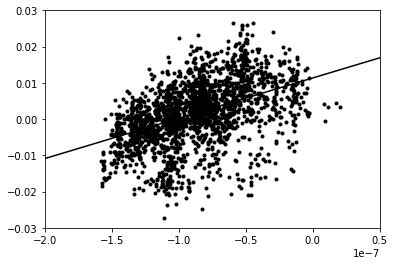

In [15]:
plt.plot(n / E, uz, 'k.')
from scipy import stats
i = np.where(np.logical_and(~np.isnan(n), ~np.isnan(uz)))
slope, intercept, r_value, p_value, std_err = stats.linregress(n[i] / E,uz[i])
print(r_value, p_value)

plt.plot([-2E-7, 0.5E-7], [slope*-2E-7+intercept, slope*0.5E-7+intercept], 'k-')
plt.axis([-2E-7, 0.5E-7, -0.03, 0.03])

In [16]:
def gaussian_filter(time, data):
    
    time_decimal_day = (time - np.min(time)).astype('timedelta64[s]').astype(np.float64) / (60.0*60.0*24.0)
        
    def inner_function(wavelength_in_days):
        
        def calculate_values(t0):
            tn = (time_decimal_day - t0) / wavelength_in_days
            i = np.where(np.logical_and(tn > -5, tn < 5))
            weights = np.exp(-0.5*np.power(tn[i],2))
            weights /= np.sum(weights)
            return np.sum(data[i]*weights)
    
        return np.vectorize(calculate_values)(time_decimal_day)
    
    return inner_function

In [17]:
t_stress = np.array(list(daterange(min_t, max_t))).astype(np.datetime64)
_, t_index, t_stress_index = np.intersect1d(t, t_stress, assume_unique=False, return_indices=True)

In [18]:
my_filter = gaussian_filter(t, co2_ts)
co2_ts_smoothed = my_filter(30.0)

0.4195209907150576 2.2404046448214586e-36


(-0.03, 0.03, 1000.0, 3500.0)

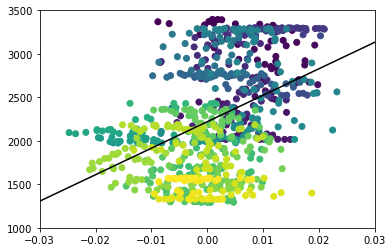

In [20]:
uz_plot = uz[t_stress_index]
co2_ts_smoothed_plot = co2_ts_smoothed[t_index]
t_plot = t[t_index]

i = np.where(np.logical_and(~np.isnan(uz_plot), ~np.isnan(co2_ts_smoothed_plot)))
uz_plot = uz_plot[i]
co2_ts_smoothed_plot = co2_ts_smoothed_plot[i]
t_plot = t[i]

plt.scatter(uz_plot, co2_ts_smoothed_plot, c=t_plot, zorder = 1)

from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(uz_plot,co2_ts_smoothed_plot)
print(r_value, p_value)

plt.plot([-0.03, 0.03], [slope*-0.03+intercept, slope*0.03+intercept], 'k-')
plt.axis([-0.03, 0.03, 1000, 3500])